# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.


We generate a random secret floating number. Then we use hamming weight model to guess the number.

We develop a method of devide-and-conquer to quickly arrive to the close number with a defined precision.

## Guessing...

In [1]:
import struct
import numpy as np
import pandas as pd
import random

# define Hamming Weight lambda function
hamming_weight = lambda x: bin(struct.unpack('@I', struct.pack('@f', x))[0]).count('1')

In [2]:
def compute_corr(secret_hw, guess_range, number_tests, known_inputs, corr=None):
        low, high = guess_range
        guess_val = np.arange(low, high, (high-low)/(number_tests-1.0+1e-5))
        muls = pd.DataFrame(columns=guess_val, data=known_inputs.reshape(-1, 1) * guess_val)
        hw = muls.applymap(lambda x: hamming_weight(x))
        hw['secret_hw'] = secret_hw
        new_corr = hw.corr(method='pearson')['secret_hw'].drop('secret_hw')
        if None is not corr:
            return pd.concat([new_corr, corr[np.logical_and(corr.index >= low, corr.index <= high)]])
        else:
            return new_corr


def guess_number_range(secret_number, guess_range, prescision, number_tests, known_inputs):
    n_cycles = 0
    secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
    common_corr = None
    while (guess_range[1] - guess_range[0]) > prescision:
        n_cycles = n_cycles + 1
        print('***[%d] guess_range =' % n_cycles, guess_range)
        range_middle_value = (guess_range[1] + guess_range[0]) / 2.0
        sub_ranges = [(guess_range[0], range_middle_value), (range_middle_value, guess_range[1])]
        low_corr = compute_corr(secret_hw, sub_ranges[0], number_tests, known_inputs, common_corr)
        high_corr = compute_corr(secret_hw, sub_ranges[1], number_tests, known_inputs, common_corr)
        
        print('low_corr =', low_corr.max(),', high_corr =', high_corr.max())
        if low_corr.max() > high_corr.max():
            guess_range = sub_ranges[0]
            common_corr = low_corr
        else:
            guess_range = sub_ranges[1]
            common_corr = high_corr
    return guess_range

## Test single point

In [3]:
#
# initalize parameter and generate a random number (secret number)
number_tests = 100
known_inputs = np.random.uniform(-1e0, 1e0, 1000) * 1e1
guess_range = (-1e0, 1.0e0)
secret_number = random.uniform(guess_range[0], guess_range[1])
prescision = 1e-4

In [4]:
guess_range = guess_number_range(secret_number, guess_range, prescision, number_tests, known_inputs)

***[1] guess_range = (-1.0, 1.0)
low_corr = 0.5232794203020305 , high_corr = 0.5747706646552629
***[2] guess_range = (0.0, 1.0)
low_corr = 0.31233449178593725 , high_corr = 0.5801708034946975
***[3] guess_range = (0.5, 1.0)
low_corr = 0.4434679803256228 , high_corr = 0.5801708034946975
***[4] guess_range = (0.75, 1.0)
low_corr = 0.5818837587481971 , high_corr = 0.4792937322822976
***[5] guess_range = (0.75, 0.875)
low_corr = 0.47648706722459794 , high_corr = 0.6389103114719653
***[6] guess_range = (0.8125, 0.875)
low_corr = 0.5581437572441117 , high_corr = 0.6413046184105192
***[7] guess_range = (0.84375, 0.875)
low_corr = 0.6904488071034105 , high_corr = 0.5283895538155906
***[8] guess_range = (0.84375, 0.859375)
low_corr = 0.6293552076871894 , high_corr = 0.7730953013035663
***[9] guess_range = (0.8515625, 0.859375)
low_corr = 0.7730953013035663 , high_corr = 0.5737261938620922
***[10] guess_range = (0.8515625, 0.85546875)
low_corr = 0.7730953013035663 , high_corr = 0.596071521702156

In [5]:
print('the secret number =', secret_number)
guessed_number = (guess_range[1] + guess_range[0]) / 2.0
print('the guessed number =', guessed_number)
error_rate = abs((guessed_number - secret_number) / secret_number) * 100
print('error rate = %0.4f' % error_rate, '%')

the secret number = 0.8517264830735785
the guessed number = 0.851715087890625
error rate = 0.0013 %


## Test multiple points

In [6]:
# initialize
guess_range = (-3e0, 3e0)
prescision = 1e-4
number_tests = 100

n_secret_numbers = 50
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/3) ),
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers/3)) * 3e-1
))

known_inputs = np.random.uniform(-1.0, 1.0, 2000) * 1e1

print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))
print('known_inputs.shape = %s' % (str(known_inputs.shape)))

secret_numbers.shape = (49,)
known_inputs.shape = (2000,)


In [7]:
results = pd.Series(index=secret_numbers, name='guessed_numbers', dtype=np.float32)
for idx in results.index:
    grange = guess_number_range(idx, guess_range, prescision, number_tests, known_inputs)
    results[idx] = (grange[1] + grange[0]) / 2.0
    print('secret_value = %f, guessed_value = %f' % (idx, results[idx]))
results.sort_index(inplace=True)

***[1] guess_range = (-3.0, 3.0)
low_corr = 0.5350292080456005 , high_corr = 0.49760670589022266
***[2] guess_range = (-3.0, 0.0)
low_corr = 0.19045402003637726 , high_corr = 0.5777513053231994
***[3] guess_range = (-1.5, 0.0)
low_corr = 0.3776874257464665 , high_corr = 0.5915074977820299
***[4] guess_range = (-0.75, 0.0)
low_corr = 0.6001104186649382 , high_corr = 0.25585483127872555
***[5] guess_range = (-0.75, -0.375)
low_corr = 0.7191582168448423 , high_corr = 0.4253361613404941
***[6] guess_range = (-0.75, -0.5625)
low_corr = 0.5945421234795663 , high_corr = 0.7213328806871837
***[7] guess_range = (-0.65625, -0.5625)
low_corr = 0.7213328806871837 , high_corr = 0.49361329982995766
***[8] guess_range = (-0.65625, -0.609375)
low_corr = 0.7213328806871837 , high_corr = 0.5382245216453352
***[9] guess_range = (-0.65625, -0.6328125)
low_corr = 0.7213328806871837 , high_corr = 0.5620803048227004
***[10] guess_range = (-0.65625, -0.64453125)
low_corr = 0.723118841792341 , high_corr = 0.60

low_corr = 0.7884039686074965 , high_corr = 0.6192845583026384
***[14] guess_range = (1.00634765625, 1.007080078125)
low_corr = 0.830165672595786 , high_corr = 0.6796292392599965
***[15] guess_range = (1.00634765625, 1.0067138671875)
low_corr = 0.6549169327856956 , high_corr = 0.8400415523749805
***[16] guess_range = (1.00653076171875, 1.0067138671875)
low_corr = 0.6927712084625561 , high_corr = 0.9073449993672303
secret_value = 1.006663, guessed_value = 1.006668
***[1] guess_range = (-3.0, 3.0)
low_corr = 0.43538062515466686 , high_corr = 0.3650201367072916
***[2] guess_range = (-3.0, 0.0)
low_corr = 0.43538062515466686 , high_corr = 0.32532416454858126
***[3] guess_range = (-3.0, -1.5)
low_corr = 0.20991616441633928 , high_corr = 0.4448282956380728
***[4] guess_range = (-2.25, -1.5)
low_corr = 0.2595026302139766 , high_corr = 0.5495125961683827
***[5] guess_range = (-1.875, -1.5)
low_corr = 0.28533931503049165 , high_corr = 0.5499482706848001
***[6] guess_range = (-1.6875, -1.5)
low_

low_corr = 0.40063463768299584 , high_corr = 0.6042681189559624
***[9] guess_range = (-1.8984375, -1.875)
low_corr = 0.5147524633208067 , high_corr = 0.6398255307491262
***[10] guess_range = (-1.88671875, -1.875)
low_corr = 0.6890572004771695 , high_corr = 0.45082694463293793
***[11] guess_range = (-1.88671875, -1.880859375)
low_corr = 0.6890572004771695 , high_corr = 0.49819598513596375
***[12] guess_range = (-1.88671875, -1.8837890625)
low_corr = 0.7275642179569517 , high_corr = 0.523314347920844
***[13] guess_range = (-1.88671875, -1.88525390625)
low_corr = 0.65698206311981 , high_corr = 0.8458963434710571
***[14] guess_range = (-1.885986328125, -1.88525390625)
low_corr = 0.8458963434710571 , high_corr = 0.5679990150567127
***[15] guess_range = (-1.885986328125, -1.8856201171875)
low_corr = 0.8458963434710571 , high_corr = 0.5928727643212078
***[16] guess_range = (-1.885986328125, -1.88580322265625)
low_corr = 0.8458963434710571 , high_corr = 0.6226277984065376
secret_value = -1.885

low_corr = 0.5173897040575061 , high_corr = 0.2756131649990016
***[3] guess_range = (0.0, 1.5)
low_corr = 0.28999653582941054 , high_corr = 0.5696201777592067
***[4] guess_range = (0.75, 1.5)
low_corr = 0.5696201777592067 , high_corr = 0.4020398877510652
***[5] guess_range = (0.75, 1.125)
low_corr = 0.3743022340279662 , high_corr = 0.6027536846517938
***[6] guess_range = (0.9375, 1.125)
low_corr = 0.524949269302283 , high_corr = 0.6188728383395006
***[7] guess_range = (1.03125, 1.125)
low_corr = 0.6653592401230836 , high_corr = 0.4473316159657669
***[8] guess_range = (1.03125, 1.078125)
low_corr = 0.6653592401230836 , high_corr = 0.49801029181945244
***[9] guess_range = (1.03125, 1.0546875)
low_corr = 0.6667902570546961 , high_corr = 0.5335932994246954
***[10] guess_range = (1.03125, 1.04296875)
low_corr = 0.5653802821762727 , high_corr = 0.7253315538430509
***[11] guess_range = (1.037109375, 1.04296875)
low_corr = 0.733690174874177 , high_corr = 0.6093454047636911
***[12] guess_range 

low_corr = 0.5393426128638457 , high_corr = 0.6202638444952077
***[15] guess_range = (2.6480712890625, 2.6484375)
low_corr = 0.5643849053559928 , high_corr = 0.6202638444952077
***[16] guess_range = (2.64825439453125, 2.6484375)
low_corr = 0.5764469801006697 , high_corr = 0.6202638444952077
secret_value = 2.648500, guessed_value = 2.648392
***[1] guess_range = (-3.0, 3.0)
low_corr = 0.42414620259379526 , high_corr = 0.3547145203072178
***[2] guess_range = (-3.0, 0.0)
low_corr = 0.35098075013696456 , high_corr = 0.452623755238906
***[3] guess_range = (-1.5, 0.0)
low_corr = 0.48689286311141183 , high_corr = 0.24219082447620224
***[4] guess_range = (-1.5, -0.75)
low_corr = 0.542150811009555 , high_corr = 0.2850706352845774
***[5] guess_range = (-1.5, -1.125)
low_corr = 0.5452888598117234 , high_corr = 0.3397973740106527
***[6] guess_range = (-1.5, -1.3125)
low_corr = 0.6281856169064115 , high_corr = 0.39720818722143336
***[7] guess_range = (-1.5, -1.40625)
low_corr = 0.414688869793219 , h

low_corr = 0.4614328177361416 , high_corr = 0.687834617184791
***[11] guess_range = (2.009765625, 2.015625)
low_corr = 0.525870917608284 , high_corr = 0.6880894361523168
***[12] guess_range = (2.0126953125, 2.015625)
low_corr = 0.7940602090917509 , high_corr = 0.5104305372927268
***[13] guess_range = (2.0126953125, 2.01416015625)
low_corr = 0.5518348278629743 , high_corr = 0.7940602090917509
***[14] guess_range = (2.013427734375, 2.01416015625)
low_corr = 0.7940602090917509 , high_corr = 0.585078880121456
***[15] guess_range = (2.013427734375, 2.0137939453125)
low_corr = 0.6140929296894712 , high_corr = 0.7940602090917509
***[16] guess_range = (2.01361083984375, 2.0137939453125)
low_corr = 0.9927135979132903 , high_corr = 0.6658126529469677
secret_value = 2.013688, guessed_value = 2.013657
***[1] guess_range = (-3.0, 3.0)
low_corr = 0.2881525918652364 , high_corr = 0.35396297614110334
***[2] guess_range = (0.0, 3.0)
low_corr = 0.22584976984759475 , high_corr = 0.37653380310900986
***[3

low_corr = 0.532594525379702 , high_corr = 0.36124145768246124
***[6] guess_range = (-1.5, -1.3125)
low_corr = 0.4148893767726212 , high_corr = 0.642848431357115
***[7] guess_range = (-1.40625, -1.3125)
low_corr = 0.642848431357115 , high_corr = 0.40192627123048674
***[8] guess_range = (-1.40625, -1.359375)
low_corr = 0.5404262314919835 , high_corr = 0.6434419575163489
***[9] guess_range = (-1.3828125, -1.359375)
low_corr = 0.6492491095112246 , high_corr = 0.45404901578581136
***[10] guess_range = (-1.3828125, -1.37109375)
low_corr = 0.6882763188913705 , high_corr = 0.4784761877745016
***[11] guess_range = (-1.3828125, -1.376953125)
low_corr = 0.7244995551837292 , high_corr = 0.5190054770652207
***[12] guess_range = (-1.3828125, -1.3798828125)
low_corr = 0.7661296999689228 , high_corr = 0.5885343065339932
***[13] guess_range = (-1.3828125, -1.38134765625)
low_corr = 0.5768136486834545 , high_corr = 0.7661296999689228
***[14] guess_range = (-1.382080078125, -1.38134765625)
low_corr = 0.

low_corr = 0.7032137302303507 , high_corr = 0.8700664336732576
secret_value = 1.626640, guessed_value = 1.626663
***[1] guess_range = (-3.0, 3.0)
low_corr = 0.6012145130096671 , high_corr = 0.5692632965843212
***[2] guess_range = (-3.0, 0.0)
low_corr = 0.3531911054583046 , high_corr = 0.6053628013813805
***[3] guess_range = (-1.5, 0.0)
low_corr = 0.4283517643858835 , high_corr = 0.7491351835870116
***[4] guess_range = (-0.75, 0.0)
low_corr = 0.7491351835870116 , high_corr = 0.37061582589574743
***[5] guess_range = (-0.75, -0.375)
low_corr = 0.569688356825783 , high_corr = 0.7491351835870116
***[6] guess_range = (-0.5625, -0.375)
low_corr = 0.7491351835870116 , high_corr = 0.446097695720068
***[7] guess_range = (-0.5625, -0.46875)
low_corr = 0.7491351835870116 , high_corr = 0.521466687501483
***[8] guess_range = (-0.5625, -0.515625)
low_corr = 0.7491351835870116 , high_corr = 0.5828639012366896
***[9] guess_range = (-0.5625, -0.5390625)
low_corr = 0.7491351835870116 , high_corr = 0.6396

low_corr = 0.48008557474417407 , high_corr = 0.2027916677951479
***[12] guess_range = (0.134765625, 0.1376953125)
low_corr = 0.48008557474417407 , high_corr = 0.3030075666012398
***[13] guess_range = (0.134765625, 0.13623046875)
low_corr = 0.23291052071283444 , high_corr = 0.533516463914508
***[14] guess_range = (0.135498046875, 0.13623046875)
low_corr = 0.27185162866009277 , high_corr = 0.5341277409285474
***[15] guess_range = (0.1358642578125, 0.13623046875)
low_corr = 0.36706608862863005 , high_corr = 0.6027148914561659
***[16] guess_range = (0.13604736328125, 0.13623046875)
low_corr = 0.6036804506097305 , high_corr = 0.37576462632908125
secret_value = 0.136102, guessed_value = 0.136093
***[1] guess_range = (-3.0, 3.0)
low_corr = 0.5157468946985947 , high_corr = 0.45911403396143485
***[2] guess_range = (-3.0, 0.0)
low_corr = 0.24929056335712507 , high_corr = 0.5361316840867553
***[3] guess_range = (-1.5, 0.0)
low_corr = 0.5553584240444815 , high_corr = 0.4956761627245278
***[4] gues

low_corr = -0.004636661837493856 , high_corr = 0.3098355499632626
***[7] guess_range = (-0.28125, -0.1875)
low_corr = 0.45781666431408236 , high_corr = 0.23232681586086662
***[8] guess_range = (-0.28125, -0.234375)
low_corr = 0.04009888264080111 , high_corr = 0.458383334072261
***[9] guess_range = (-0.2578125, -0.234375)
low_corr = 0.12607584314333403 , high_corr = 0.4588585268912292
***[10] guess_range = (-0.24609375, -0.234375)
low_corr = 0.18679105496241993 , high_corr = 0.45999448522269204
***[11] guess_range = (-0.240234375, -0.234375)
low_corr = 0.26291846287050336 , high_corr = 0.46015334472446734
***[12] guess_range = (-0.2373046875, -0.234375)
low_corr = 0.522493721227651 , high_corr = 0.3158433716351111
***[13] guess_range = (-0.2373046875, -0.23583984375)
low_corr = 0.32166775995137237 , high_corr = 0.5225871433364013
***[14] guess_range = (-0.236572265625, -0.23583984375)
low_corr = 0.6588239974148811 , high_corr = 0.38748996125760476
***[15] guess_range = (-0.236572265625,

low_corr = 0.5888999358484946 , high_corr = 0.5446164889159922
***[2] guess_range = (-3.0, 0.0)
low_corr = 0.2309746738734726 , high_corr = 0.5908328530203967
***[3] guess_range = (-1.5, 0.0)
low_corr = 0.31405725148213715 , high_corr = 0.6618071685465636
***[4] guess_range = (-0.75, 0.0)
low_corr = 0.6618071685465636 , high_corr = 0.32470649929041245
***[5] guess_range = (-0.75, -0.375)
low_corr = 0.47216145626061223 , high_corr = 0.6756712962647136
***[6] guess_range = (-0.5625, -0.375)
low_corr = 0.7419818562947323 , high_corr = 0.5007702248168262
***[7] guess_range = (-0.5625, -0.46875)
low_corr = 0.5727189363118178 , high_corr = 0.7420557476494882
***[8] guess_range = (-0.515625, -0.46875)
low_corr = 0.7420557476494882 , high_corr = 0.5752766331973644
***[9] guess_range = (-0.515625, -0.4921875)
low_corr = 0.7420557476494882 , high_corr = 0.6283249479496332
***[10] guess_range = (-0.515625, -0.50390625)
low_corr = 0.6328711907892052 , high_corr = 0.7878246332928511
***[11] guess_r

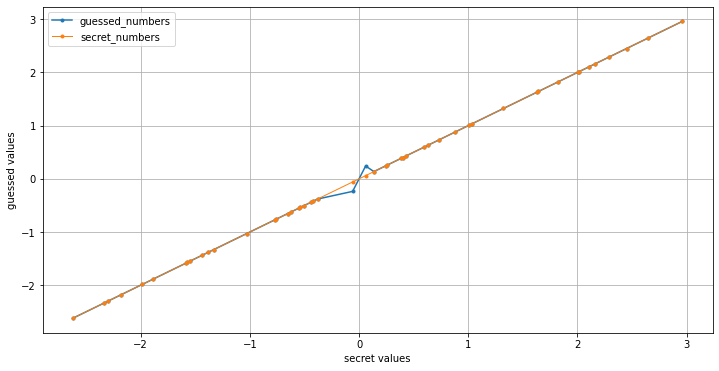

In [8]:
ax = results.plot(figsize = (12, 6), marker='.')
ax.plot(results.index, results.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.grid(True)

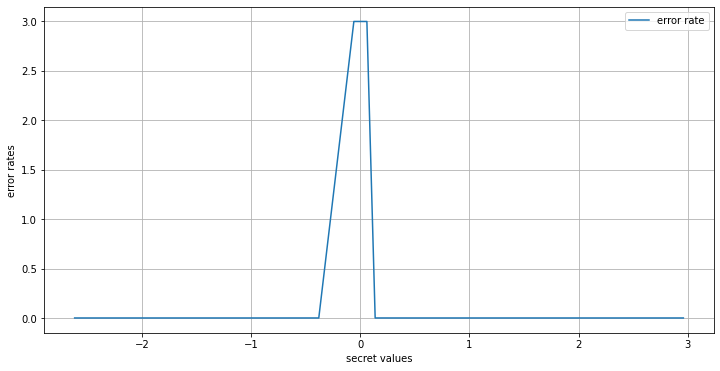

In [9]:
error_rate = ((results - results.index)/results.index).abs()
ax = error_rate.plot(figsize = (12, 6), label='error rate')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.grid(True)

# Batinna method

In [10]:
def batina_guess_number(secret_number, guess_range, prescision, known_inputs):
    low, high = guess_range
    guess_val = np.arange(low, high, prescision)
    print('matrix size = %d x %d' % (len(known_inputs), len(guess_val)))
    hw = pd.DataFrame(columns=guess_val, data=known_inputs.reshape(-1, 1) * guess_val)
    hw['actual'] = known_inputs * secret_number
    print('calculate correlation...')
    corr = hw.applymap(lambda x: hamming_weight(x)).corr(method='pearson')
    return corr['actual'].drop('actual').idxmax()

In [11]:
batinta_results = pd.Series(index=secret_numbers, name='guessed_numbers', dtype=np.float32)
for idx in batinta_results.index:
    # we have to reduce the precision, otherwise, it takes too long time to run
    batinta_results[idx] = batina_guess_number(idx, guess_range, prescision * 100, known_inputs)
    print('secret_value = %f, guessed_value = %f' % (idx, batinta_results[idx]))
batinta_results.sort_index(inplace=True)    

matrix size = 2000 x 600
calculate correlation...
secret_value = -0.653375, guessed_value = -0.650000
matrix size = 2000 x 600
calculate correlation...
secret_value = 2.009778, guessed_value = 2.010000
matrix size = 2000 x 600
calculate correlation...
secret_value = -0.425812, guessed_value = -0.430000
matrix size = 2000 x 600
calculate correlation...
secret_value = 2.959521, guessed_value = 2.960000
matrix size = 2000 x 600
calculate correlation...
secret_value = 1.006663, guessed_value = 1.010000
matrix size = 2000 x 600
calculate correlation...
secret_value = -1.572283, guessed_value = -1.570000
matrix size = 2000 x 600
calculate correlation...
secret_value = 2.110733, guessed_value = 2.110000
matrix size = 2000 x 600
calculate correlation...
secret_value = -0.380379, guessed_value = -0.380000
matrix size = 2000 x 600
calculate correlation...
secret_value = 2.292316, guessed_value = 2.290000
matrix size = 2000 x 600
calculate correlation...
secret_value = -1.885957, guessed_value = 

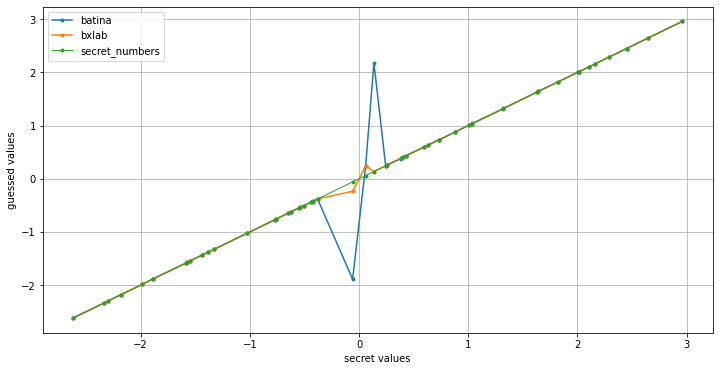

In [12]:
ax = batinta_results.plot(figsize = (12, 6), marker='.', label='batina')
results.plot(ax=ax, marker='.', label='bxlab')
ax.plot(batinta_results.index, batinta_results.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.grid(True)

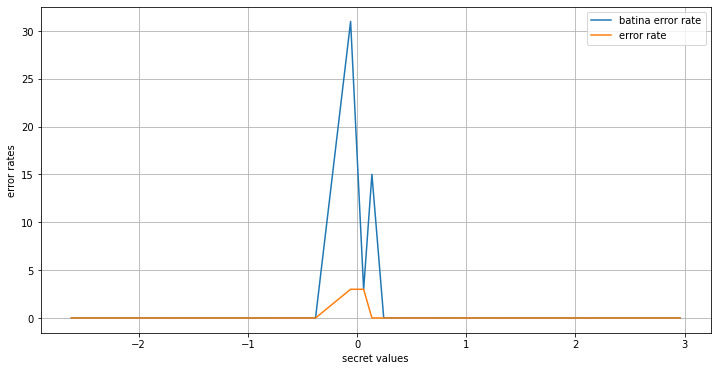

In [13]:
batina_error_rate = ((batinta_results - batinta_results.index)/batinta_results.index).abs()
ax = batina_error_rate.plot(figsize = (12, 6), label='batina error rate')
ax = error_rate.plot(ax=ax, label='error rate')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.grid(True)